In [1]:
# Import the required libraries and dependencies
import os
from pathlib import Path
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics

In [3]:
load_dotenv()

True

In [4]:
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [7]:
type(alpaca_api_key)
type(alpaca_secret_key)

str

In [6]:
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

tickers = ["MSFT"]
timeframe = "1D"
start_date = pd.Timestamp("today", tz="America/New_York").isoformat()
end_date = pd.Timestamp("today", tz="America/New_York").isoformat()
limit_rows = 1

In [7]:
current_msft_price_df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = limit_rows
).df

current_msft_price_df.head()

MSFT                               
                             open    high  low   close    volume
time                                                            
2021-11-02 00:00:00-04:00  330.21  333.45  330  333.26  21366225

In [10]:
msft_close_price = float(current_msft_price_df["MSFT"]["close"])
print(msft_close_price)

333.26


In [11]:
msft_div = pd.read_csv(Path("Resources/msft_dividends.csv"))
msft_div.iloc[:,0] = pd.to_datetime(msft_div.iloc[:,0])
msft_div.head()


,Announced,Period,Amount,Yield,Ex-Dividend,Record Date,Payable Date
0,2021-09-14,quarterly,$0.62,0.83%,11/17/2021,11/18/2021,12/9/2021
1,2021-06-16,quarterly,$0.56,0.87%,8/18/2021,8/19/2021,9/9/2021
2,2021-03-16,quarterly,$0.56,0.94%,5/19/2021,5/20/2021,6/10/2021
3,2020-12-02,quarterly,$0.56,1.04%,2/17/2021,2/18/2021,3/11/2021
4,2020-09-15,quarterly,$0.56,1.07%,11/18/2020,11/19/2020,12/10/2020


In [12]:
msft_div.loc[:, "Yield"]= msft_div.loc[:, "Yield"].str.replace("%", "")
msft_div.loc[:, "Yield"]= msft_div.loc[:, "Yield"].astype("float")

msft_div.dtypes

Announced       datetime64[ns]
Period                  object
Amount                  object
Yield                  float64
Ex-Dividend             object
Record Date             object
Payable Date            object
dtype: object

In [14]:
msft_div_slices = msft_div.loc[:, "Yield"]
msft_div_slices_average = round(msft_div_slices.mean(),2)
msft_div_slices_average
print(f"The average yearly dividend for Microsoft is: {msft_div_slices_average}% over the last 10 years.")

The average yearly dividend for Microsoft is: 1.75% over the last 10 years.


<AxesSubplot:xlabel='Announced '>

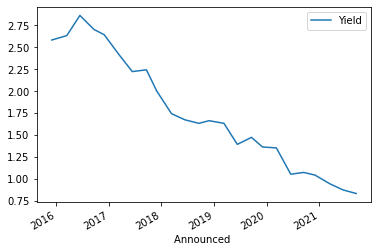

In [15]:
msft_div.plot(x= "Announced ", y= "Yield")
#Should we use the Average Yearly Dividend over the simulated time frame? It seems too high and I feel like it would only ever decrease.
#If the dividend yield is decreasing because the stock price is increasing, then does that mean considering MSFT simulated growth, the yield would decrease even further?


#Suggestion: Run linear regression to progress the dividend yield graph even further. Return the predicted yield into a list and plot it out.

#import numpy as np
# from sklearn.linear_model import LinearRegression



<AxesSubplot:xlabel='Date'>

<AxesSubplot:xlabel='Date'>

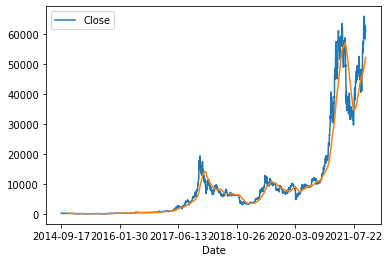

In [18]:
btc_data =pd.read_csv(Path("./Resources/BTC-USD.csv"))
display(btc_data.plot(x="Date", y="Close", rot = 45))
btc_data.drop(columns = "Adj Close", inplace =True)
btc_data.head()

btc_sma = btc_data["Close"].rolling(window = 60).mean().dropna()
btc_sma.plot()

,Date,Open,High,Low,Close,Volume,pct_change
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,-0.071926
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700.0,-0.069843
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,0.035735
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100.0,-0.024659
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600.0,0.008352


count    2598.000000
mean        0.002658
std         0.039113
min        -0.371695
25%        -0.012831
50%         0.002032
75%         0.018448
max         0.252472
Name: pct_change, dtype: float64

<AxesSubplot:ylabel='Frequency'>

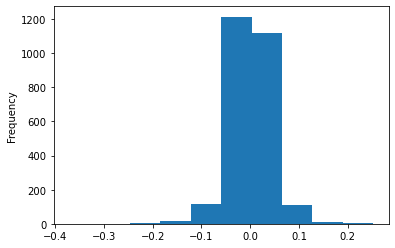

In [45]:
btc_data_pct = btc_data
btc_data_pct["pct_change"] = btc_data["Close"].pct_change()
btc_data_pct.dropna(inplace = True)
display(btc_data_pct.head())

display(btc_data_pct["pct_change"].describe())
btc_data_pct["pct_change"].plot.hist()

#This does not look like a normal distribution so I do not recommend a Monte Carlo Simulation?

In [21]:
btc_data.columns = btc_data.columns.str.lower()
# btc_data = pd.concat({'BTC': btc_data}, axis = 1)
#Comment this out because there already is an additional level

btc_data.head()


BTC                                                            
         date        open        high         low       close      volume
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800.0
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700.0
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600.0
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100.0

In [24]:
MC_ten_year_btc = MCSimulation(portfolio_data = btc_data, 
                      num_simulation= 1000,
                      num_trading_days= 252*10)
MC_ten_year_btc.portfolio_data.head()


BTC                                                              \
         date        open        high         low       close      volume   
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800.0   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200.0   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700.0   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600.0   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100.0   

                
  daily_return  
0          NaN  
1    -0.071926  
2    -0.069843  
3     0.035735  
4    -0.024659

In [35]:
MC_simulated_return = MC_ten_year_btc.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

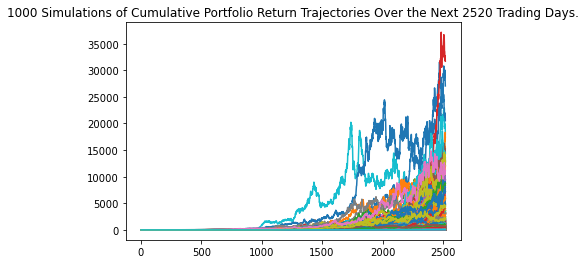

In [29]:
MC_ten_year_btc.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

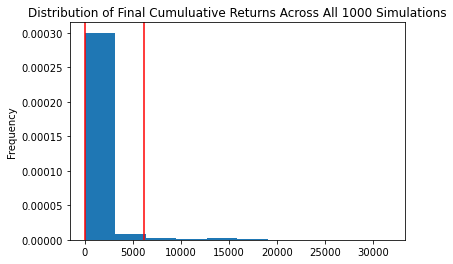

In [33]:
MC_ten_year_btc.plot_distribution()

In [32]:
MC_ten_year_summary_statistics = round(MC_ten_year_btc.summarize_cumulative_return(), 3)
MC_ten_year_summary_statistics

count            1000.000
mean              752.129
std              2350.361
min                 0.347
25%                35.758
50%               111.883
75%               487.523
max             31691.961
95% CI Lower        2.871
95% CI Upper     6170.672
Name: 2520, dtype: float64

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.027094,1.052963,1.056751,0.896137,1.023571,0.950878,1.033804,1.018071,1.021332,0.935363,...,1.086245,0.975323,1.001891,1.020002,1.007687,1.071932,0.957707,0.982351,0.977594,0.987479
2,1.002968,0.992267,1.103348,0.907347,1.024066,0.943012,1.133211,1.132575,1.022322,0.893617,...,1.081391,0.912875,1.018159,1.077351,0.983205,1.035380,0.957292,0.962013,0.949485,0.999466
3,0.979292,0.994599,1.106130,0.944035,0.986449,0.974084,1.104358,1.177322,0.961947,0.940558,...,1.054866,0.965280,1.022824,1.042112,0.956428,1.083953,0.979126,0.992043,0.912803,1.044270
4,1.013256,0.964709,1.126199,0.910831,0.954972,1.009901,1.112106,1.232231,0.974194,0.930621,...,1.053455,0.940655,0.969562,1.102385,0.922080,1.105703,0.948832,0.996824,0.965823,1.065726


<AxesSubplot:title={'center':'Average of 1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days'}, ylabel='Return'>

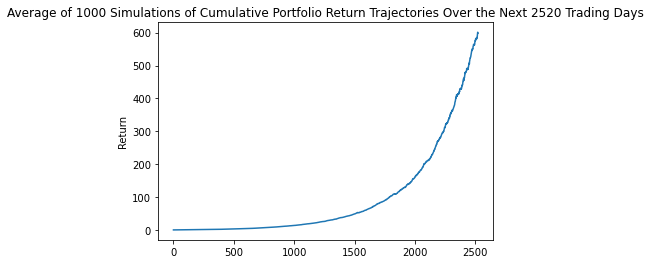

In [46]:
display(MC_simulated_return.head())
MC_single_graph = MC_simulated_return.mean(axis = 1)
MC_single_graph.plot(title  ="Average of 1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days", ylabel = "Return")